In [48]:
library(variableStars)
library(data.table)
library(ggplot2)
library(RColorBrewer)
library(plotly)
library(keras)
library(plotly)
library(abind)
library(fields)

### Read processed files and create big matrix with all rows

In [56]:
setwd("~/Downloads/data/")
system("cat *.log > ALL.log")
df_all <- data.frame(fread("ALL.log", sep=",", header = F))
dim(df_all)
df_all <- df_all[complete.cases(df_all),]
dim(df_all)

[1] 16952   614

[1] 16952   614

### Experiment parameters

In [57]:
# Resolution for target frequency [0-100]
input_resolution <- 0.5
output_resolution <- 1.0

# Input dimension
cuts_breaks <- c(-Inf, seq(0, 101, input_resolution), Inf)
input_dim <- length(cuts_breaks) - 1

# Output dimension
num_classes <-
  length(seq(
    from = 0.1,
    to = 14 / 0.0864,
    by = output_resolution
  )) # Buckets of possible classes

### Matrix creation from data

In [58]:
rows <- dim(df_all)[1]
cols <- (dim(df_all)[2] - 2) / 3
dimensions <- 3 # Number of channels
X <- array(0, c(rows, cols, dimensions))
# Y train is a 1D matrix with rows and targets
Y <- matrix(0, nrow = rows, ncol = num_classes)


ind_data <- seq(from=1,to=rows)

# Reshaoe dataframe to matrix slices
X[ind_data, , 1] <- as.matrix(df_all[ind_data, 1:204])
X[ind_data, , 2] <- as.matrix(df_all[ind_data, 204:((204 * 2) - 1)])
X[ind_data, , 3] <- as.matrix(df_all[ind_data, (204 * 2):((204 * 3) - 1)])
Y <- to_categorical(df_all[ind_data, 614:614], num_classes)

dim(X)
dim(Y)

[1] 16952   204     3

[1] 16952   162

In [59]:
ind_remove_no_target <- which(apply(Y,1,sum)==1)
paste0("Removing ",length(ind_remove_no_target==F)," rows with NO target")

X <- X[ind_remove_no_target,,]
Y <- Y[ind_remove_no_target,]

dim(X)
dim(Y)

[1] "Removing 16952 rows with NO target"

[1] 16952   204     3

[1] 16952   162

In [60]:
stopifnot(which(is.na(Y))==FALSE)
stopifnot(which(is.na(X))==FALSE)

In [61]:
# Split train/test
smp_size <- floor(0.75 * nrow(X))
set.seed(123)
ind <- sample(seq_len(nrow(X)), size = smp_size)

# Prepare partition
x_train <- X[ind, , ]
x_test  <- X[-ind, , ]
y_train <- Y[ind, ]
y_test  <- Y[-ind, ]
# Check dims
dim(x_train)
dim(y_train)
dim(x_test)
dim(y_test)

[1] 13561   204     3

[1] 13561   162

[1] 3391  204    3

[1] 3391  162

### EDA of data

ERROR: Error in eval(expr, envir, enclos): 


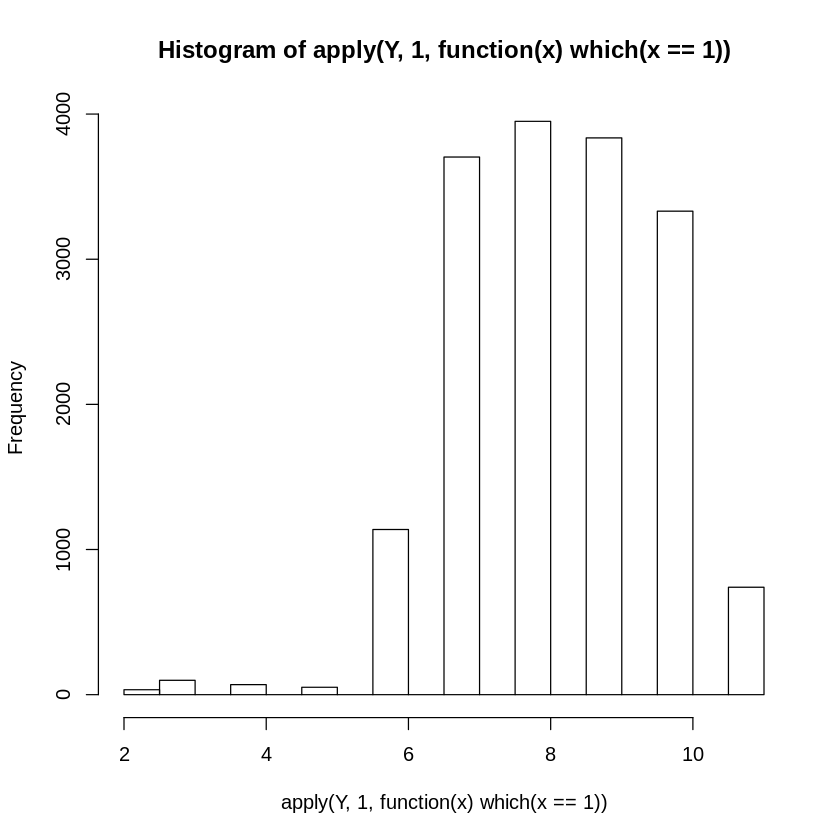

In [62]:
hist(apply(Y,1,function(x) which(x==1)))
stop()

### NN train

In [ ]:
top_12_categorical_accuracy <-
  custom_metric("rec_at_12", function(y_true, y_pred) {
    metric_top_k_categorical_accuracy(y_true, y_pred, 12)
  })
top_6_categorical_accuracy <-
  custom_metric("recat_6", function(y_true, y_pred) {
    metric_top_k_categorical_accuracy(y_true, y_pred, 6)
  })
top_4_categorical_accuracy <-
  custom_metric("rec_at_4", function(y_true, y_pred) {
    metric_top_k_categorical_accuracy(y_true, y_pred, 4)
  })
top_2_categorical_accuracy <-
  custom_metric("rec_at_2", function(y_true, y_pred) {
    metric_top_k_categorical_accuracy(y_true, y_pred, 2)
  })


# Create a 1d convolutional NN
model <- keras_model_sequential() %>%
  layer_separable_conv_1d(
    kernel_size = 5,
    filters = 8,
    depth_multiplier = 15,
    input_shape = c(204, 3)
  ) %>%
  layer_max_pooling_1d(pool_size = 2) %>%
  layer_dropout(0.2) %>%
  layer_batch_normalization() %>%

layer_separable_conv_1d(
    kernel_size = 5,
    filters = 8,
    depth_multiplier = 15,
    input_shape = c(204, 3)
  ) %>%
  layer_max_pooling_1d(pool_size = 2) %>%
  layer_dropout(0.2) %>%
  layer_batch_normalization() %>%

  
  layer_flatten() %>%
  layer_dense(units = num_classes, activation = 'softmax')



# Configure a model for categorical classification.
model %>% compile(
  loss = "categorical_crossentropy",
  optimizer = optimizer_adadelta(lr = 0.01),
  metrics = c(
          "accuracy",
          top_2_categorical_accuracy,
          top_4_categorical_accuracy,
          top_6_categorical_accuracy,
          top_12_categorical_accuracy
        )
)
summary(model) # Plot summary

# Fit model
  history <- model %>% fit(
    x_train,
    y_train,
    epochs = 8000,
    batch_size =  250,
    validation_split = 0.2,
    shuffle = T,
    verbose = 2
  )

In [ ]:
#save_model_hdf5(model, paste0("~/Downloads/model_dnu",".h5"))
evaluate(model, x_test, y_test)

In [ ]:
plot(history) +
  theme_bw()

### Confusion matrix

In [ ]:
Y_test_hat <- predict_classes(model, x_test)
# Calculate confusion matrix
cm <- table(apply(y_test,1,which.max), Y_test_hat)

# Plot matrix
dtCM <- as.data.frame(cm)
colnames(dtCM) <- c("c1","c2","freq")
ggplot(data=dtCM, aes(c1, c2, fill = freq)) +
  geom_raster() +
  scale_fill_gradientn(colours=c("#0000FFFF","#FFFFFFFF","#FF0000FF"))

In [ ]:
select_test <- 1000

y_hats <- predict(model, x_test)

plot(
  y_hats[select_test,],
  lty = 1,
  ylim = c(0, 1),
  xlim = c(0, 120),
  col = "black",
  xlab = "Frequency",
  ylab = "Prob / Value"
)

lines(x_test[select_test, , 1], lty = 1, col = "blue")
lines(x_test[select_test, , 2], lty = 2, col = "grey")
lines(x_test[select_test, , 3], lty = 3, col = "orange")


abline(
  v = which(y_test[select_test, ]==1)[1],
  col = "red",
  lwd = 3,
  lty = 2
)

abline(
  v = which(y_test[select_test, ]==1)[2],
  col = "red",
  lwd = 3,
  lty = 2
)

legend(
  "topright",
  c("FT", "Diffs", "Autocorrelation"),
  lty = c(1, 2, 3, 4),
  col = c("blue", "grey", "orange")
)